In [1]:
import os
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime
from matplotlib import gridspec
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 13,   # X-axis tick labels
    'ytick.labelsize' : 13,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')

plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)

<module 'compute_ensemble_stats' from '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC/compute_ensemble_stats.py'>

In [2]:
importlib.reload(putil)
importlib.reload(ces)

freq='monthly'

# ----- set signifiance threshold
pcrit = 0.05
    
# ----- ploting settings
isiglw      = 2.5      # significance contour linewidth
isigcolor   = 'w'      # significance contour color
ihatch      = '////'  # insignificance hatching type
ihatchlw    = 1        # insignificance hatching linewidth
ihatchcolor = 'w'      # insignificance hatching color
ucolor      = 'k'      # contour color for variable
ulw         = 1.1      # line width for variable contours
ulwz        = ulw*1.5  # line width for variable zero-line
ualph       = 0.75     # alpha for variable contours
eqcolor     = 'k'      # equator line color 
eqls        = ':'      # equator linestyle
eqlw        = 1.75      # equator line width
eqalph      = 0.66      # equator alpha
ercolor     = 'yellow' # eruption line color 
erls        = '-'      # eruption linestyle
erlw        = 2        # eruption line width
mpl.rcParams['hatch.linewidth'] = ihatchlw
mpl.rcParams['hatch.color']     = ihatchcolor

In [3]:
importlib.reload(putil)
importlib.reload(ces)

def make_plot(var, ptype, ax, p, mass, ulev=None, tsel=None, colorbar=False, legend=False, icmap='RdBu_r', label_contours=True, years=7, cbpos=None):
    
    
    vargs = {'skip_nosrctag':True, 'mass':mass, 'freq':freq, 
             'average_lat':False, 'average_time':False, 'average_pres':False}
    
    dummy_args=copy.deepcopy(vargs)
    dummy_args['tmin']=date(1991,6,1)
    dummy_args['tmax']=date(1991,7,1)
    dummy_args['latmin']=-1
    dummy_args['latmax']=1
    dummy_var = putil.get_variable('U', **dummy_args)
    plev = dummy_var['cfmean'].plev
    
    if(ptype=='timelat'):
        pp = float(plev.sel(plev=p, method='nearest').values)
        vargs['tmin'], vargs['tmax'] = date(1991,6,1), date(1991+years,7,1)
        vargs['pmin'], vargs['pmax'] = pp-0.01, pp+0.01
        vargs['overwrite'] = False
    elif(ptype=='latlev'):
        vargs['tmin'], vargs['tmax'] = tsel.start, tsel.stop
        #vargs['pmin'], vargs['pmax'] = p.start, p.stop
        vargs['overwrite'] = False
        trop = putil.get_variable('TROP_P', **vargs)
    # -- read data
    data = putil.get_variable(var, **vargs)
    # -- get dims
    time, lat = data['ensmean'].time, data['ensmean'].lat
    time = [datetime(t.year,t.month,t.day) for t in time.values]
    timelim = [time[0], time[-1]]
    
    _, _, ax_wsize, ax_hsize = ax.get_position().bounds
    if(cbpos is not None):
        # colorbar position
        cbheight = 0.77
        cbpos    = [0.94, (1-cbheight)/2-0.005, 0.025, cbheight]
    
    # select data at pressure level or slice
    if(ptype == 'timelat'): 
        for ds in data.keys(): 
            data[ds]=data[ds].sel(plev=p, method='nearest')
        x, y = time, lat
        pp = lambda d: d.transpose('lat','time')
        latlim  = [-90, 90]
    if(ptype == 'latlev'):  
        for ds in data.keys():
            data[ds]=data[ds].sel(plev=p, time=tsel).mean('time').T
        x, y = lat, data['ensmean'].plev
        pp = lambda d: d.transpose('plev','lat')
        latlim  = [-90, 90]
        
    # --- scale data from days to years, apply scaling, get units
    scaling  = {'AOA':1/365, 'psitem':1/1e7, 'E90j':1e9, 'wtem':1000, 'vtem':1}[var]
    iscaling = {'AOA':1/30, 'psitem':1/1e7, 'E90j':1e10, 'wtem':1000, 'vtem':1}[var]
    for ds in data.keys():
        if(ds not in ['coherence', 'pval', 'impact']):
            data[ds] = data[ds] * scaling
        if(ds == 'impact'):
            data[ds] = data[ds] * iscaling
            
    # ---- get units, names
    units   = {'AOA':'years', 'psitem':'10$^7$ kg s$^{-1}$', 'E90j':'10$^{-1}$ ppb', 'wtem':'mm s$^{-1}$', 'vtem':'m s$^{-1}$'}[var]
    iunits  = {'AOA':'months', 'psitem':'10$^7$ kg s$^{-1}$', 'E90j':'10$^{-1}$ ppb', 'wtem':'mm s$^{-1}$', 'vtem':'m s$^{-1}$'}[var]
    varname = {'AOA':'AOA', 'psitem':'$\\Psi^*$', 'E90j':'E90', 'wtem':'$w^*$', 'vtem':'$v^*$'}[var]
    ivarname = {'AOA':'AOA', 'psitem':'$\\Psi^*$', 'E90j':'E90', 'wtem':'$w^*$', 'vtem':'$v^*$'}[var]
    
    # --- plot counterfactual ensemble data
    cfc  = ax.contour(x, y, pp(data['cfmean']), colors=ucolor, linewidths=ulw, levels=np.array(ulev)[np.array(ulev)!=0], alpha=ualph, zorder=10)
    cfcz = ax.contour(x, y, pp(data['cfmean']), colors=ucolor, linewidths=ulwz, levels=[0], alpha=ualph, zorder=10)
    # --- plot impact data
    icf = ax.contourf(x, y, pp(data['impact']), cmap=icmap, levels=ilev, norm=inorm, extend='both') 

    # ---- plot tropopause
    if(ptype=='latlev'):
        ax.plot(x, trop['cfmean'].mean('time')/100, color='magenta', lw=4)
        
    # --- plot pval contours and hashing           
    ax.contourf(x, y, pp(data['pval']), levels=[pcrit, data['pval'].max()], hatches=[ihatch], colors='w',alpha=0)
    ax.contour(x, y, pp(data['pval']), colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    
    # ---- label CF contours
    if(label_contours):
        ax.clabel(cfc, inline=True)
        ax.clabel(cfcz, inline=True)

    # ---- plot eruption marker, equator line
    if(ptype=='timelat'):
        # --- plot equator line
        ax.axhline(y=0, color=eqcolor, ls=eqls, lw=eqlw, alpha=eqalph, zorder=11)
        # --- plot eruption marker
        #ax.axvline(x=datetime(1991, 6, 15), color=ercolor, ls=erls, lw=erlw, zorder=12)
        ax.scatter([datetime(1991, 6, 15)], [15], marker='^', color='k', linewidths=1, edgecolors='w', s=200, zorder=12)
    if(ptype=='timelat'):
        # --- plot equator line
        ax.axvline(x=0, color=eqcolor, ls=eqls, lw=eqlw, alpha=eqalph, zorder=11)

    # ----- make colorbars
    if(colorbar):
        icbar = fig.colorbar(icf, cax=fig.add_axes(cbpos), orientation='vertical', location='right', extendrect=True)
        icbar.set_label('{} impact [{}]'.format(ivarname, iunits), fontsize=15)
        icbar.set_ticklabels(np.array(ilev).astype(int))
        icbar.set_ticks(ilev)

    # ----- make legend
    if(legend):
        dummy = ax.plot([0,0],[0,0], color=ucolor, lw=ulw, alpha=ualph,label='counterfactual {} [{}]'.format(varname, units))
        #leg = ax.legend(bbox_to_anchor=(0.5, -2.35), frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=15, loc='center')
        leg = ax.legend(bbox_to_anchor=(1.01, -0.27), frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=15, loc='lower right')
        #leg = ax.legend(frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=15, loc='upper right')
        leg.get_frame().set_linewidth(0.66)

    # ----- make pressure label box
    if(ptype=='timelat'):
        ax.text(0.87, 0.19, '{} hPa'.format(p), transform=ax.transAxes, verticalalignment='top', fontsize=20, zorder=1000,
                bbox=dict(facecolor='w', edgecolor='k'))

    # ----- format
    if(ptype=='timelat'):
        ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
        ax.set_ylim(latlim)
        ax.set_xlim(timelim)
        #putil.season_timeticks(ax, time, 'season', include_year=True)
        putil.season_timeticks(ax, time, 'solstice', include_year=True, year_on_jan_only=True)
        putil.format_lataxis(ax, which='y')
    if(ptype=='latlev'):
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_xlim(latlim)
        ax.set_ylim(y.min(), y.max())
        putil.format_lataxis(ax, which='x')
        putil.format_paxis(ax)
        

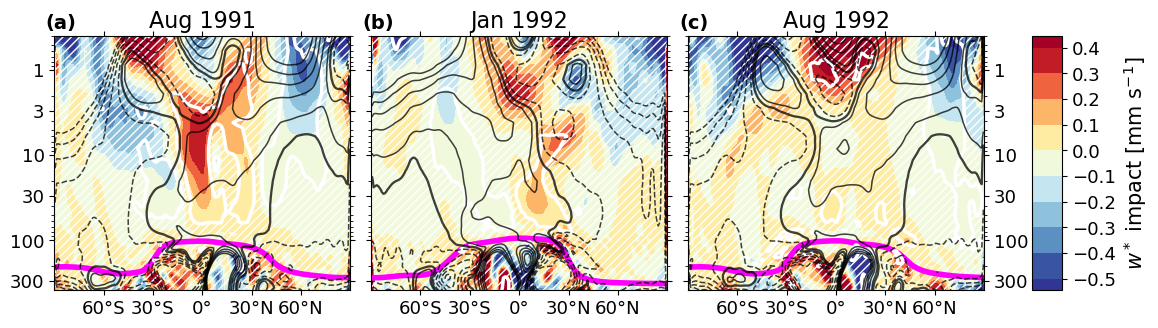

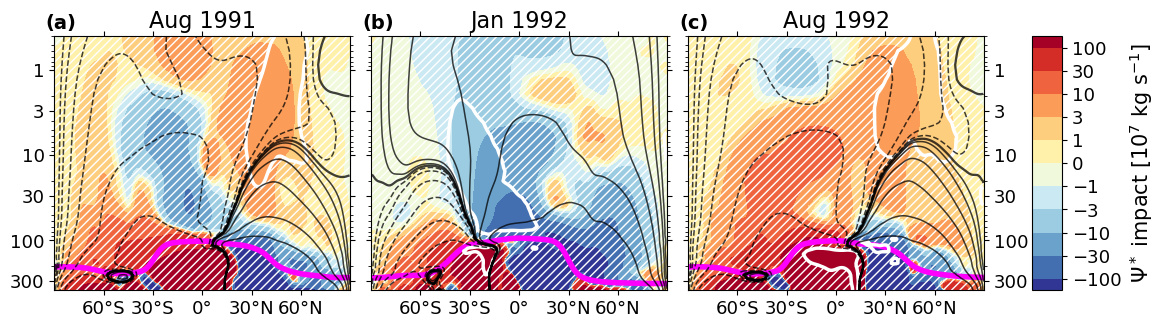

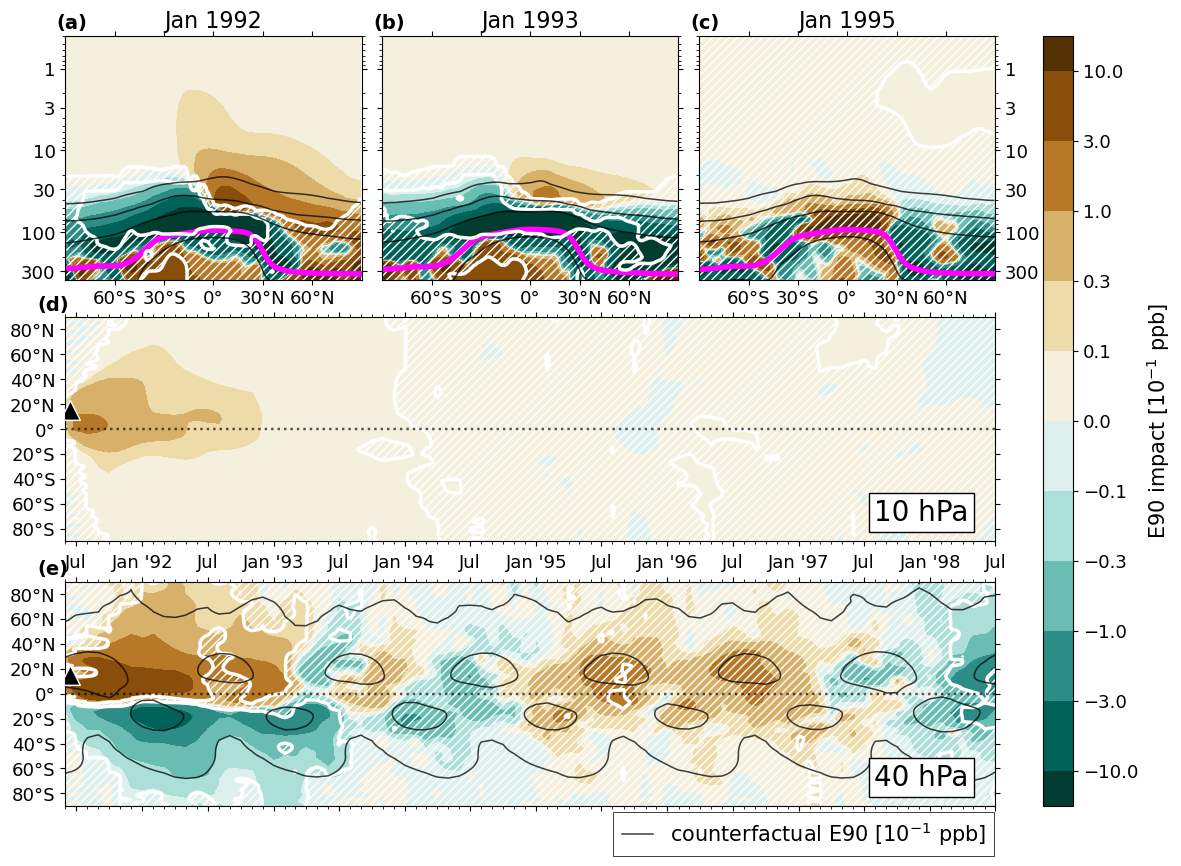

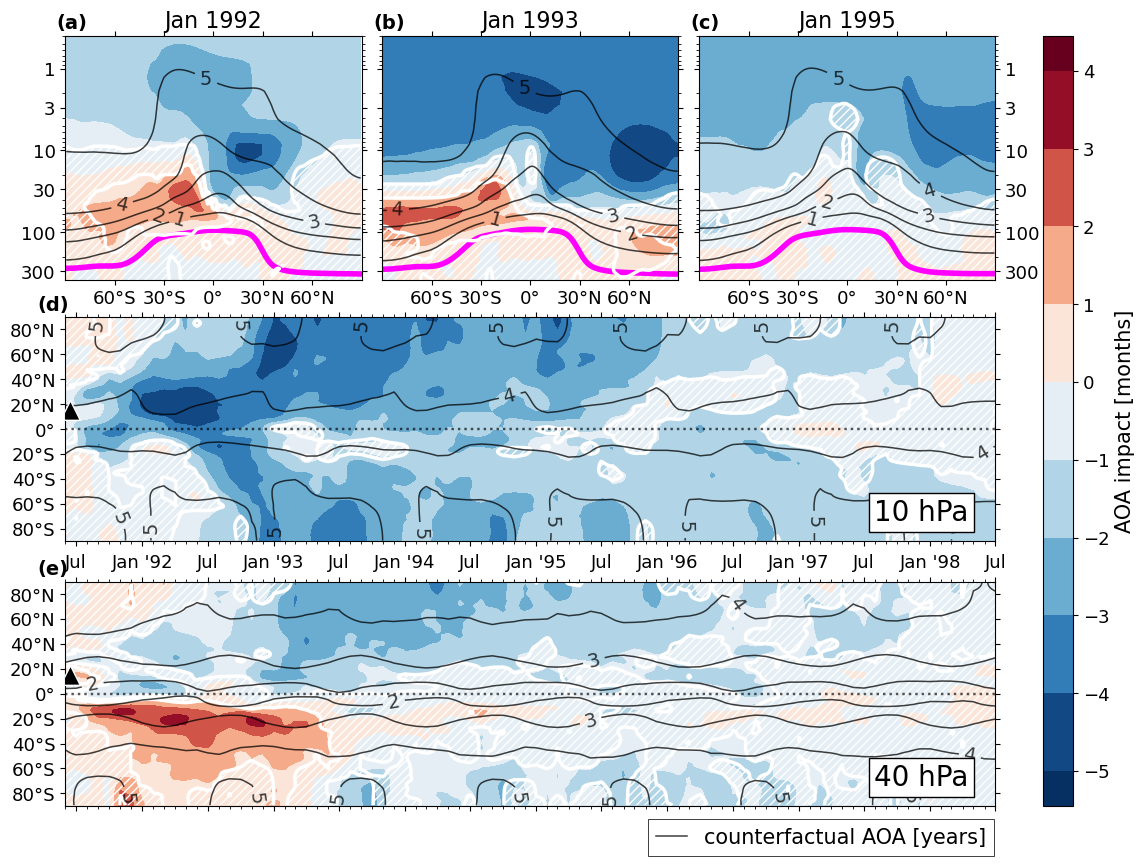

In [5]:
importlib.reload(putil)
importlib.reload(ces)

var = ['wtem', 'psitem', 'E90j', 'AOA']

for vari in var:
    for mass in [15]:

        if(vari not in ['E90j','AOA']):
            fig = plt.figure(figsize=(12,3.3))
            gs  = gridspec.GridSpec(1, 3, figure=fig, wspace=0.07)
            ax0 = fig.add_subplot(gs[0,0])
            ax1 = fig.add_subplot(gs[0,1])
            ax2 = fig.add_subplot(gs[0,2])
            cbheight = 0.77
            cbpos    = [0.94, (1-cbheight)/2-0.005, 0.025, cbheight]
        else:
            fig = plt.figure(figsize=(12,10))
            gs  = gridspec.GridSpec(2, 1, height_ratios=[0.5,1], figure=fig, hspace=0.1)
            gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.07)
            gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0.18)
            ax0 = fig.add_subplot(gs1[0,0])
            ax1 = fig.add_subplot(gs1[0,1])
            ax2 = fig.add_subplot(gs1[0,2])
            ax3 = fig.add_subplot(gs2[0,0])
            ax4 = fig.add_subplot(gs2[1,0])
            cbpos    = [0.9, 0, 0.25, 1]

        # ---------- configuration per variable
        
        if(vari == 'AOA'):
            ulev  = np.arange(0, 20, 1)
            ilev  = np.arange(-5, 4.1, 1)
            ulevpp1, ulevpp2 = ulev, ulev
            inorm = putil.get_cmap_norm(ilev, 'twoslope')
            lc=True
            tsel = [slice(date(1992,1,1), date(1992,2,1)), 
                    slice(date(1993,1,1), date(1993,2,1)), 
                    slice(date(1995,1,1), date(1995,2,1))]
            years = 7
            pp1, pp2 = 10, 40
            cmap = 'RdBu_r'
            
        if(vari == 'E90j'):
            ulev  = np.hstack([[0.01, 0.1, 1, 10], np.arange(50, 151, 25)])*10
            ilev  = np.array([0.01, 0.03, 0.1, 0.3, 1])*10
            ilev  = np.hstack([-ilev[::-1], [0], ilev])
            ulevpp1, ulevpp2 = ulev, ulev
            inorm = putil.get_cmap_norm(ilev, 'uneven')
            lc=False
            tsel = [slice(date(1992,1,1), date(1992,2,1)), 
                    slice(date(1993,1,1), date(1993,2,1)), 
                    slice(date(1995,1,1), date(1995,2,1))]
            years = 7
            pp1, pp2 = 10, 40
            cmap = 'BrBG_r'
        
        if(vari == 'psitem'):
            ulev    = [-300, -100, -30, -10, -3, -1, 0, 1, 3, 10, 30, 100, 300]
            ilev    = [-100, -30, -10, -3, -1, 0, 1, 3, 10, 30, 100]
            ulevpp1 = [-100, -30, -10, 0, 10, 30, 100]
            ulevpp2 = [-300, -100, -30, 0, 30, 100, 300]
            inorm = putil.get_cmap_norm(ilev, 'uneven')
            lc=False
            tsel = [slice(date(1991,8,1), date(1991,9,1)), 
                    slice(date(1992,1,1), date(1992,2,1)), 
                    slice(date(1992,8,1), date(1992,9,1))]
            years = 3
            pp1, pp2 = 3, 30
            cmap = 'RdYlBu_r'
            
        if(vari == 'wtem'):
            ulev = np.arange(-3, 3, 0.66)
            ilev = np.arange(-0.5, 0.5, 0.1)
            ulevpp1=ulev
            ulevpp2=ulev
            inorm = putil.get_cmap_norm(ilev, 'twoslope')
            lc=False
            tsel = [slice(date(1991,8,1), date(1991,9,1)), 
                    slice(date(1992,1,1), date(1992,2,1)), 
                    slice(date(1992,8,1), date(1992,9,1))]
            years = 3
            pp1, pp2 = 3, 30
            cmap = 'RdYlBu_r'
       
        if(vari == 'vtem'):
            ulev = np.arange(-4, 4, 0.5)
            ilev = np.arange(-0.2, 0.201, 0.05)
            ulevpp1=ulev
            ulevpp2=ulev
            inorm = putil.get_cmap_norm(ilev, 'twoslope')
            lc=False
            tsel = [slice(date(1991,8,1), date(1991,9,1)), 
                    slice(date(1992,1,1), date(1992,2,1)), 
                    slice(date(1992,8,1), date(1992,9,1))]
            years = 3
            pp1, pp2 = 3, 30
            cmap = 'RdYlBu_r'
            
        # -------- plotting

        # plot time-lat at levels
        if(vari in ['wtem','psitem']): cbb=True
        else:                          cbb=False
        make_plot(vari,'latlev',  ax0,  mass=mass, ulev=ulev, p=slice(0.3, 400), tsel=tsel[0], label_contours=lc, years=years, icmap=cmap, colorbar=cbb, cbpos=cbpos)
        make_plot(vari,'latlev',  ax1,  mass=mass, ulev=ulev, p=slice(0.3, 400), tsel=tsel[1], label_contours=lc, years=years, icmap=cmap)
        make_plot(vari,'latlev',  ax2,  mass=mass, ulev=ulev, p=slice(0.3, 400), tsel=tsel[2], label_contours=lc, years=years, icmap=cmap)

        if(vari not in ['wtem', 'psitem']):
            make_plot(vari,'timelat', ax3,  mass=mass, ulev=ulevpp1, p=pp1, colorbar=True, label_contours=lc, years=years, icmap=cmap, cbpos=cbpos)
        if(vari not in ['wtem','psitem']):
            make_plot(vari,'timelat', ax4,  mass=mass, ulev=ulevpp2, p=pp2, legend=True, label_contours=lc, years=years, icmap=cmap, cbpos=cbpos)

        # titles
        dd = [datetime(tsel[i].start.year, tsel[i].start.month, tsel[i].start.day) for i in range(len(tsel))] 
        ax0.set_title('{} {}'.format(dd[0].strftime("%b"), tsel[0].start.year), fontsize=16)
        ax1.set_title('{} {}'.format(dd[1].strftime("%b"), tsel[1].start.year), fontsize=16)
        ax2.set_title('{} {}'.format(dd[2].strftime("%b"), tsel[2].start.year), fontsize=16)

        # format axes
        putil.format_ticks(ax0)
        putil.format_ticks(ax1, y=None)
        putil.format_ticks(ax2, y='right')
        if(vari not in ['wtem','psitem']):
            putil.format_ticks(ax3, x=None)
            putil.format_ticks(ax4, x='top')

        # ---- subplot labels
        letter = ['(a)','(b)','(c)','(d)', '(e)']
        if(vari not in ['wtem','psitem']): axx = [ax0, ax1, ax2, ax3, ax4]
        else: axx = [ax0, ax1, ax2]
        for i, axi in enumerate(axx):
            axi.annotate(letter[i], xy=(-0.03, 1.03), xycoords="axes fraction", fontsize=14, weight = 'bold')

        plt.savefig('figs/{}Tg_{}_impact_summary.pdf'.format(mass, vari), dpi=250, bbox_inches='tight')
        plt.show()